# IMAGE CLASSIFICATION USING MOBILENET

The objective of this notebook is to classify the histopathological images using MobileNet, which is a simple but efficient and not very computationally intensive convolutional neural networks. The dataset used for this classification model is the [LC25000 LUNG AND COLON HISTOPATHOLOGICAL IMAGE DATASET](https://github.com/tampapath/lung_colon_image_set). This dataset contains 25,000 histopathological images with 5 classes, each with 5,000 images, being:

1.   Lung benign tissue
2.   Lung adenocarcinoma
3.   Lung squamous cell carcinoma
4.   Colon adenocarcinoma
5.   Colon benign tissue

All images are 768 x 768 pixels in size and are in jpeg file format.


In [1]:
cd /home/student/Documents/dataset

/home/student/Documents/dataset


In [2]:
ls /home/student/Documents/dataset

colon_aca/  lung_aca/  lung_scc/
colon_n/    lung_n/    training_history_mobilenet.csv


### Loading dataset
Loading Dataset directly from the dirctory and then create a tf.data.Dataset for training and validation using the tf.keras.utils.image_dataset_from_directory utility.

In [3]:
import tensorflow as tf

data_dir = "/home/student/Documents/dataset"

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  labels = "inferred",
  label_mode = 'categorical',
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(224,224),
  batch_size=32)


2023-09-27 10:21:17.113160: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-27 10:21:17.233718: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-09-27 10:21:17.233739: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-09-27 10:21:17.257888: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-27 10:21:17.845467: W tensorflow/stream_executor/platform/de

Found 25000 files belonging to 5 classes.
Using 22500 files for training.


2023-09-27 10:21:19.561632: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-09-27 10:21:19.561680: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tech-OptiPlex-9020): /proc/driver/nvidia/version does not exist
2023-09-27 10:21:19.562297: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  labels = "inferred",
  label_mode = 'categorical',
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(224,224),
  batch_size=32)


Found 25000 files belonging to 5 classes.
Using 2500 files for validation.


### Plotting Sample Data

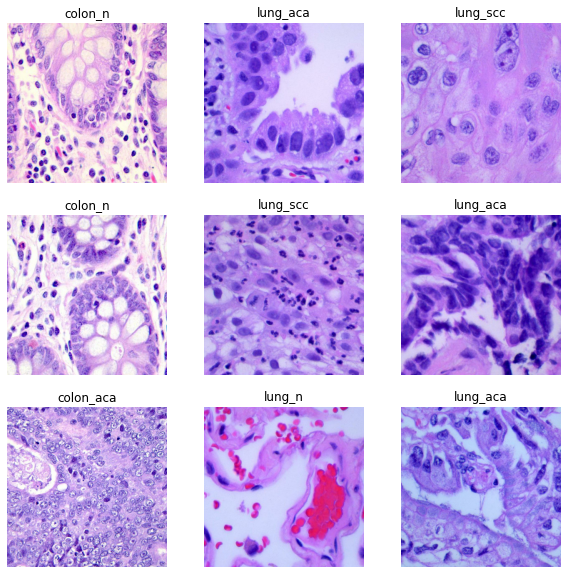

In [7]:
import matplotlib.pyplot as plt
import numpy 

class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[numpy.argmax(labels[i])])
    plt.axis("off")

To create a test dataset, move 20% data from the train set

In [8]:
train_ds_batches = tf.data.experimental.cardinality(train_ds)
test_ds = train_ds.take(train_ds_batches // 6)
train_ds = train_ds.skip(train_ds_batches // 6)

In [9]:
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_ds))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of train batches: 587
Number of validation batches: 79
Number of test batches: 117


## MobileNet Model Architecture

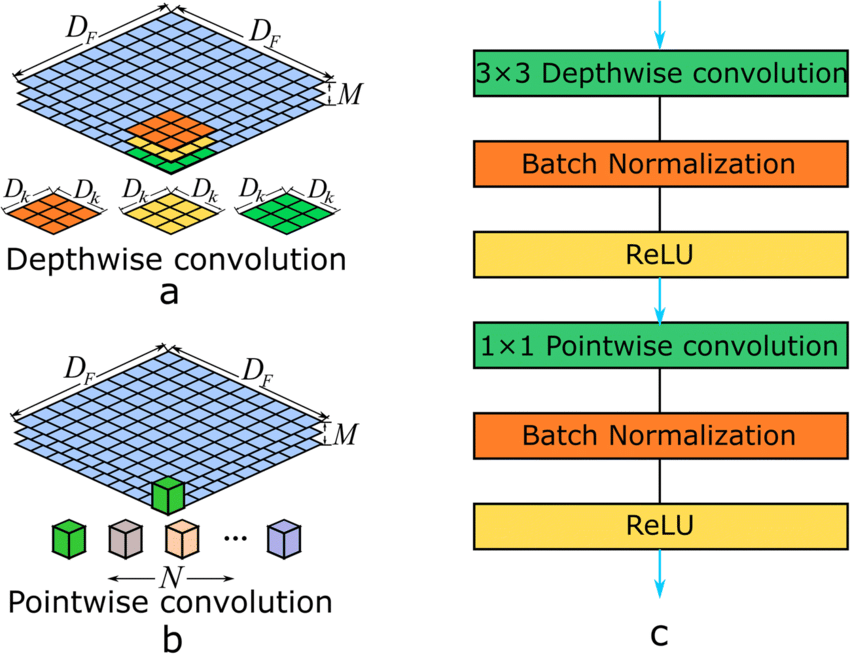
Neural Network Architecture of MobileNet. a Depthwise Convolution layer. b Pointwise Convolution layer. c Depthwise Separable convolutions with Depthwise and Pointwise layers followed by batchnorm and ReLU

### Model building

In [10]:
import tensorflow as tf
from keras.models import Sequential 
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.models import Model


model = Sequential()
model.add(MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(5, activation='softmax'))
model.layers[0].trainable=False             
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 5)                 5125      
                                                                 
Total params: 3,233,989
Trainable params: 5,125
Non-trainable params: 3,228,864
_________________________________________________________________


### Compile the model

In [11]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

### Fit the model

In [12]:
history = model.fit(train_ds, epochs = 10, validation_data=val_ds, batch_size = 32)

Epoch 1/10
587/587 [==============================] - 323s 479ms/step - loss: 0.3663 - accuracy: 0.8735 - val_loss: 0.2290 - val_accuracy: 0.9212
Epoch 2/10
587/587 [==============================] - 261s 440ms/step - loss: 0.2041 - accuracy: 0.9263 - val_loss: 0.1897 - val_accuracy: 0.9292
Epoch 3/10
587/587 [==============================] - 252s 425ms/step - loss: 0.1721 - accuracy: 0.9371 - val_loss: 0.1774 - val_accuracy: 0.9316
Epoch 4/10
587/587 [==============================] - 287s 484ms/step - loss: 0.1532 - accuracy: 0.9429 - val_loss: 0.1571 - val_accuracy: 0.9380
Epoch 5/10
587/587 [==============================] - 285s 432ms/step - loss: 0.1393 - accuracy: 0.9475 - val_loss: 0.1436 - val_accuracy: 0.9428
Epoch 6/10
587/587 [==============================] - 251s 422ms/step - loss: 0.1303 - accuracy: 0.9516 - val_loss: 0.1586 - val_accuracy: 0.9328
Epoch 7/10
587/587 [==============================] - 251s 424ms/step - loss: 0.1238 - accuracy: 0.9533 - val_loss: 0.1351 -

In [13]:
import pandas as pd
import numpy as np
hist = pd.DataFrame(history.history)
hist.to_csv('training_history_mobilenet1.csv', index=False)
print(hist)

       loss  accuracy  val_loss  val_accuracy
0  0.366318  0.873480  0.229020        0.9212
1  0.204148  0.926317  0.189698        0.9292
2  0.172142  0.937140  0.177377        0.9316
3  0.153236  0.942898  0.157064        0.9380
4  0.139323  0.947483  0.143576        0.9428
5  0.130272  0.951642  0.158556        0.9328
6  0.123781  0.953295  0.135090        0.9464
7  0.117470  0.957400  0.154532        0.9308
8  0.112533  0.958520  0.121597        0.9536
9  0.107422  0.959586  0.118790        0.9532


In [14]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

117/117 [==============================] - 45s 385ms/step - loss: 0.1056 - accuracy: 0.9589
Test accuracy : 0.9588675498962402


### Accuracy and loss graph

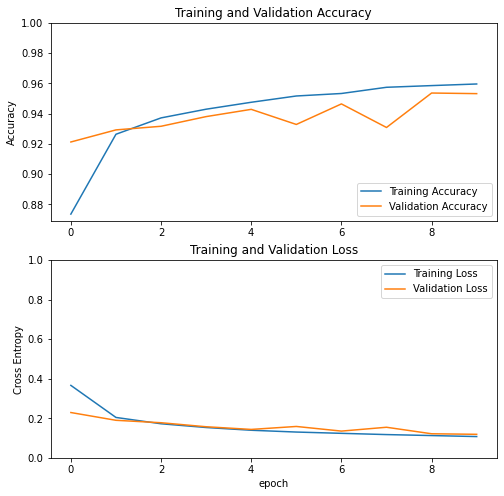

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Predicting the Testset

1/1 [==============================] - 1s 787ms/step


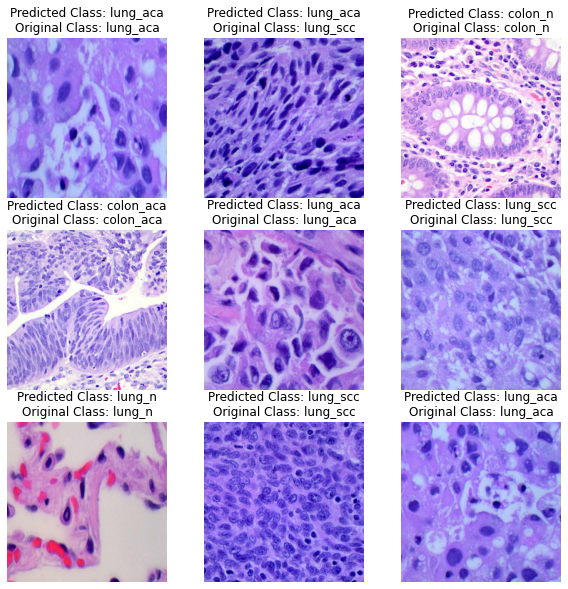

In [16]:
import matplotlib.pyplot as plt
import numpy 

plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    make_predictions = model.predict(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        title = f"Predicted Class: {class_names[numpy.argmax(make_predictions[i])]}\nOriginal Class: {class_names[numpy.argmax(labels[i])]}"
        plt.title(title, fontsize=12, loc='center')
        plt.axis("off")


### Confusion Matrix

1/1 [==============================] - 0s 357ms/step


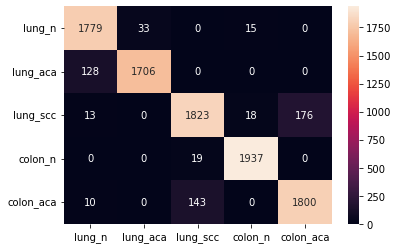

In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


y_true = []
y_pred = []
for k in range(25):
    for images, labels in test_ds.take(k):
        make_predictions = model.predict(images)
        for i in range(32):
            y_pred.append(class_names[numpy.argmax(make_predictions[i])])
            y_true.append(class_names[numpy.argmax(labels[i])])

label = set(y_true)

sns.heatmap(confusion_matrix(y_true,y_pred),xticklabels=label,yticklabels=label,annot=True, fmt='d')
plt.show()